In [ ]:
### Information Extraction using rebel

In [1]:
from openie import StanfordOpenIE
import csv 
import spacy



In [2]:
TEXT = 'Tesla CEO Elon Musk sold $6.9 billion worth of shares , \
he said that the funds could be used to finance Twitter if he loses a legal battle with it.\
Tesla factory in Austin was shut for two days, Laila Shahrokhshahi reports.\
Tesla Inc has hired former Hewlett Packard lawyer Derek Windham to helm its legal team.'

In [5]:
import requests
#Enitity Linking/wikification
def perform_wikification(item):
  try:
    url = f"https://www.wikidata.org/w/api.php?action=wbsearchentities&search={item}&language=en&format=json"
    data = requests.get(url).json()
     
    return data['search'][0]['id']
  except:
    return "no-data"

In [6]:
custom_ner_model = spacy.load("../models/spacy_model")

In [7]:

doc = custom_ner_model(TEXT)
for ent in doc.ents:
    print(ent.text,ent.label_)

Tesla CUSTOM_ORG
CEO CUSTOM_ROLE
Elon Musk CUSTOM_PERSON
Twitter CUSTOM_ORG
Tesla CUSTOM_ORG
Austin CUSTOM_PLACE
Laila Shahrokhshahi CUSTOM_PERSON
Tesla Inc CUSTOM_ORG
Hewlett CUSTOM_ORG
Packard lawyer CUSTOM_ROLE
Derek Windham CUSTOM_PERSON


In [8]:
# Function to parse the generated text and extract the triplets from babel
#https://github.com/Babelscape/rebel

def extract_triplets(text):
    triplets = []
    relation, subject, relation, object_ = '', '', '', ''
    text = text.strip()
    current = 'x'
    for token in text.replace("<s>", "").replace("<pad>", "").replace("</s>", "").split():
        if token == "<triplet>":
            current = 't'
            if relation != '':
                triplets.append({'subject': subject.strip(), 'relation': relation.strip(),'object': object_.strip()})
                relation = ''
            subject = ''
        elif token == "<subj>":
            current = 's'
            if relation != '':
                triplets.append({'subject': subject.strip(), 'relation': relation.strip(),'object': object_.strip()})
            object_ = ''
        elif token == "<obj>":
            current = 'o'
            relation = ''
        else:
            if current == 't':
                subject += ' ' + token
            elif current == 's':
                object_ += ' ' + token
            elif current == 'o':
                relation += ' ' + token
    if subject != '' and relation != '' and object_ != '':
        triplets.append({'subject': subject.strip(), 'relation': relation.strip(),'object': object_.strip()})
    return triplets

In [9]:
from transformers import pipeline

triplet_extractor = pipeline('text2text-generation', model='Babelscape/rebel-large', tokenizer='Babelscape/rebel-large',device=-1)

In [10]:
import pandas as pd

In [11]:
custom_ner_model = spacy.load("../models/spacy_model")

def triple_generation(text,only_custom_entities = False):
    df = pd.DataFrame(columns = ["subject", "object", "relation"])
    knowledge_base = dict()
    nlp = spacy.load("en_core_web_lg")
    doc = nlp(text)
    for sent in doc.sents:
        # We need to use the tokenizer manually since we need special tokens.
        extracted_text = triplet_extractor.tokenizer.batch_decode([triplet_extractor(sent.text, return_tensors=True, return_text=False)[0]["generated_token_ids"]])
        extracted_triplets = extract_triplets(extracted_text[0])
        for triple in extracted_triplets:
            subject = triple['subject']
            obj = triple['object']
            #If we need extract relaions of only custom entities
            if only_custom_entities:
                doc = custom_ner_model(text)
                custom_entities  = [i.text for i in doc.ents]
                #If either subject or object not presentin custom entities list then set them as None,ignore them
                if not any(x in [subject,obj] for x in custom_entities):
                    subject = None
                    obj = None
                
            if None not in [subject,obj]:
                #Get wiki id and add to existing knowledge base
                #If it is already present then use existing id fromknowledge base.
                #This logic will avoid duplication and use first occurance of entity as a reference
                entity_wiki_id = perform_wikification(subject) 
                if entity_wiki_id in knowledge_base:
                    subject = knowledge_base[entity_wiki_id]
                else:
                    knowledge_base[entity_wiki_id] = subject

                
                entity_wiki_id = perform_wikification(obj) 
                if entity_wiki_id in knowledge_base:
                    obj = knowledge_base[entity_wiki_id]
                else:
                    knowledge_base[entity_wiki_id] = obj
                            
                df = df.append({'subject' : subject, 'object' : obj,'relation' :triple['relation']} , 
                        ignore_index=True)
    
    return df 

In [12]:
print(triple_generation (TEXT))

C:\Users\metes\AppData\Local\Temp\ipykernel_32860\33296474.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'subject' : subject, 'object' : obj,'relation' :triple['relation']} ,
C:\Users\metes\AppData\Local\Temp\ipykernel_32860\33296474.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'subject' : subject, 'object' : obj,'relation' :triple['relation']} ,
C:\Users\metes\AppData\Local\Temp\ipykernel_32860\33296474.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'subject' : subject, 'object' : obj,'relation' :triple['relation']} ,


         subject           object               relation
0      Elon Musk          Twitter               owner of
1        Twitter        Elon Musk               owned by
2          Tesla           Austin  headquarters location
3  Derek Windham  Hewlett Packard               employer


C:\Users\metes\AppData\Local\Temp\ipykernel_32860\33296474.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'subject' : subject, 'object' : obj,'relation' :triple['relation']} ,


In [13]:
import networkx as nx
import matplotlib.pyplot as plt


def get_graph_plot(df):
    G = nx.from_pandas_edgelist(
        df, "subject", "object", edge_attr=True, create_using=nx.MultiDiGraph()
    )
    edge_labels = dict(
        [((x, y), z) for x, y, z in zip(df.subject, df.object, df.relation)]
    )

    # plt.figure(figsize=(10, 10))

    pos = nx.spring_layout(G)
    nx.draw(
        G,
        with_labels=True,
        node_color="skyblue",
        edge_cmap=plt.cm.Blues,
        pos=pos,
    )
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)
    return plt

C:\Users\metes\AppData\Local\Temp\ipykernel_32860\33296474.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'subject' : subject, 'object' : obj,'relation' :triple['relation']} ,
C:\Users\metes\AppData\Local\Temp\ipykernel_32860\33296474.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'subject' : subject, 'object' : obj,'relation' :triple['relation']} ,
C:\Users\metes\AppData\Local\Temp\ipykernel_32860\33296474.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'subject' : subject, 'object' : obj,'relation' :triple['relation']} ,
C:\Users\metes\AppData\Local\Temp\ipykernel_32860\33296474.py:41: FutureWarning: The frame.append method is deprecated and will be removed 

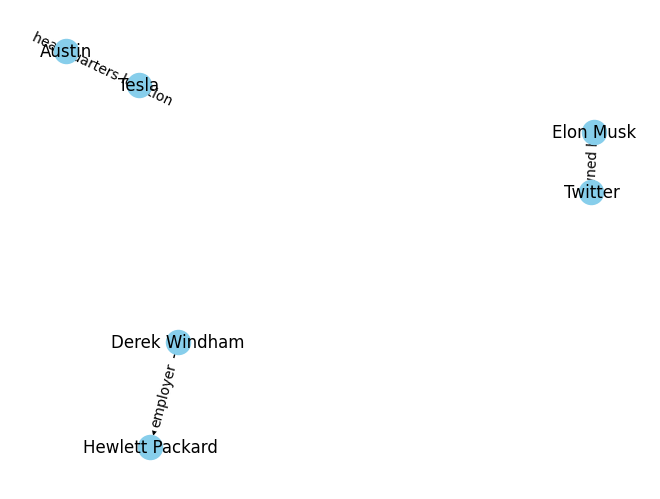

In [14]:
get_graph_plot(triple_generation (TEXT)).show()

In [ ]:
### Information Extraction using Stanford Openie

In [66]:
custom_ner_model = spacy.load("../models/spacy_model")
client = StanfordOpenIE()
def triple_generation_stanford(text,only_custom_entities = False):
    df = pd.DataFrame(columns = ["subject", "object", "relation"])
    knowledge_base = dict()
    #Iterate through sentences
    nlp = spacy.load("en_core_web_lg")
    doc = nlp(text)
    for sent in doc.sents:
        for triple in client.annotate(sent.text):
            subject = triple['subject']
            obj = triple['object']
            #If we need extract relaions of only custom entities
            if only_custom_entities:
                doc = custom_ner_model(text)
                custom_entities  = [i.text for i in doc.ents]
                #If either subject or object not presentin custom entities list then set them as None,ignore them
                if not any(x in [subject,obj] for x in custom_entities):
                    subject = None
                    obj = None
                
            if None not in [subject,obj]:
                #Get wiki id and add to existing knowledge base
                #If it is already present then use existing id fromknowledge base.
                #This logic will avoid duplication and use first occurance of entity as a reference
                entity_wiki_id = perform_wikification(subject) 
                if entity_wiki_id in knowledge_base:
                    subject = knowledge_base[entity_wiki_id]
                else:
                    knowledge_base[entity_wiki_id] = subject

                
                entity_wiki_id = perform_wikification(obj) 
                if entity_wiki_id in knowledge_base:
                    obj = knowledge_base[entity_wiki_id]
                else:
                    knowledge_base[entity_wiki_id] = obj
                            
                df = df.append({'subject' : subject, 'object' : obj,'relation' :triple['relation']} , 
                        ignore_index=True)
    
    return df 

C:\Users\metes\AppData\Roaming\Python\Python38\site-packages\spacy\util.py:837: UserWarning: [W095] Model 'en_pipeline' (0.0.0) was trained with spaCy v3.4 and may not be 100% compatible with the current version (3.3.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [68]:
#print(triple_generation_stanford ("Barack Obama was born in Hawaii."))